In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import datetime,timedelta
import pandas as pd
import seaborn as sns

In [2]:
data= pd.read_csv('train_anonimized.csv',parse_dates=['DATE'])
pd.set_option('display.max_rows', None)
data

NAICS_DESC       DATE  REVENUE  \
0                  Commercial Banking 2021-08-30       22   
1                  Commercial Banking 2021-08-31       98   
2                  Commercial Banking 2021-09-01       77   
3                  Commercial Banking 2021-09-02       82   
4                  Commercial Banking 2021-09-03       76   
5                  Commercial Banking 2021-09-07       30   
6                  Commercial Banking 2021-09-08       39   
7                  Commercial Banking 2021-09-09       96   
8                  Commercial Banking 2021-09-10      130   
9                  Commercial Banking 2021-09-13       31   
10                 Commercial Banking 2021-09-14      136   
11                 Commercial Banking 2021-09-15       39   
12                 Commercial Banking 2021-09-16       39   
13                 Commercial Banking 2021-09-17       70   
14                 Commercial Banking 2021-09-20      100   
15                 Commercial Banking 2021-09-21       91   
16                 Commercial Banking 2021-09-22      244   
17                 Commercial Banking 2021-09-23      117   
18                 Commercial Banking 2021-09-24      144   
19                 Commercial Banking 2021-09-27      100   
20                 Commercial Banking 2021-09-28       54   
21                 Commercial Banking 2021-09-29      176   
22                 Commercial Banking 2021-09-30       85   
23                 Commercial Banking 2021-10-01       70   
24                 Commercial Banking 2021-10-04       99   
25                 Commercial Banking 2021-10-05      117   
26                 Commercial Banking 2021-10-06      181   
27                 Commercial Banking 2021-10-07      116   
28                 Commercial Banking 2021-10-08       71   
29                 Commercial Banking 2021-10-11      135   
30                 Commercial Banking 2021-10-12       91   
31                 Commercial Banking 2021-10-13      129   
32                 Commercial Banking 2021-10-14      105   
33                 Commercial Banking 2021-10-15      447   
34                 Commercial Banking 2021-10-18      101   
35                 Commercial Banking 2021-10-19       69   
36                 Commercial Banking 2021-10-20       85   
37                 Commercial Banking 2021-10-21       84   
38                 Commercial Banking 2021-10-22      102   
39                 Commercial Banking 2021-10-25      176   
40                 Commercial Banking 2021-10-26      241   
41                 Commercial Banking 2021-10-27      228   
42                 Commercial Banking 2021-10-28      114   
43                 Commercial Banking 2021-10-29      187   
44                 Commercial Banking 2021-11-02      142   
45                 Commercial Banking 2021-11-03      144   
46                 Commercial Banking 2021-11-04      141   
47                 Commercial Banking 2021-11-05       96   
48                 Commercial Banking 2021-11-07       27   
49                 Commercial Banking 2021-11-08      148   
50                 Commercial Banking 2021-11-09      154   
51                 Commercial Banking 2021-11-10      142   
52                 Commercial Banking 2021-11-12      204   
53                 Commercial Banking 2021-11-15      223   
54                 Commercial Banking 2021-11-16      199   
55                 Commercial Banking 2021-11-17      190   
56                 Commercial Banking 2021-11-18      208   
57                 Commercial Banking 2021-11-19       86   
58                 Commercial Banking 2021-11-22      145   
59                 Commercial Banking 2021-11-23      204   
60                 Commercial Banking 2021-11-24       97   
61                 Commercial Banking 2021-11-28       17   
62                 Commercial Banking 2021-11-29      135   
63                 Commercial Banking 2021-11-30      270   
64                 Commercial Banking 2021-12-01      385   
6

In [3]:
count_null = pd.DataFrame(data.isnull().sum(), columns = ['Null Values'])
count_null

Null Values
NAICS_DESC              2592
DATE                       0
REVENUE                    0
anonimized_name            0

In [4]:
data.fillna('Unknown', inplace = True)

In [5]:
from datetime import datetime

import datetime
snapshot_date=max(data.DATE)+datetime.timedelta(days=1)

clients=data.groupby(['anonimized_name']).agg({'DATE': lambda x:
                                             (snapshot_date-x.max()).days,
                                             'NAICS_DESC':'count',
                                             'REVENUE':'sum'})
clients.rename(columns={'DATE':'Recency',
                          'NAICS_DESC':'Frequency',
                          'REVENUE':'MonetaryValue'}, inplace=True)

In [6]:
clients.sample(5)

Recency  Frequency  MonetaryValue
anonimized_name                                         
Ruth Hoffman INC             1        419        2734358
Todd Young INC               1        407        6133011
David Moody INC              1        175         754844
Jessica Hendricks INC        1        550        3407745
Phyllis Hess INC             1        221        1039534

In [7]:
#Building RFM segments
R_labels=range(1,3)
F_labels=range(1,5)
M_labels=range(1,5)

R_quartiles=pd.cut(clients['Recency'],bins=2,labels=R_labels)
F_quartiles = pd.qcut(clients['Frequency'],q=4,labels=F_labels)
M_quartiles = pd.qcut(clients['MonetaryValue'],q=4,labels=M_labels)

RFM=clients.assign(R=R_quartiles,F=F_quartiles,M=M_quartiles)

In [8]:
# Build RFM Segment and RFM Score
def add_rfm(x) : return str(x['R'])+str(x['F']) + str(x['M'])
                             
RFM['RFM_Segment'] = RFM.apply(add_rfm,axis=1 )
RFM['RFM_Score'] = RFM[['R','F','M']].sum(axis=1)

In [9]:
RFM.sample(5)

Recency  Frequency  MonetaryValue  R  F  M RFM_Segment  \
anonimized_name                                                              
Rebecca Castro INC       10          3            668  2  1  1         211   
Robert Yoder INC          1        321        1103971  1  2  1         121   
Brian Moore INC           1        768        7566217  1  4  4         144   
Gary Nguyen INC           1        642        2969086  1  3  3         133   
Daniel George INC         1        536        4615165  1  3  3         133   

                    RFM_Score  
anonimized_name                
Rebecca Castro INC          4  
Robert Yoder INC            4  
Brian Moore INC             9  
Gary Nguyen INC             7  
Daniel George INC           7

In [10]:
RFM.groupby('RFM_Score').agg({'Recency':'mean',
                             'Frequency':'mean',
                             'MonetaryValue': ['mean', 'count'] }).round(2)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3             1.0    155.44     620825.56     9
4             2.8    223.00    1110771.00     5
5             1.0    323.80    1680998.60     5
6             1.0    767.40    1982975.00     5
7             1.0    556.88    3971032.50    16
8             1.0    639.67    5971544.00     3
9             1.0    909.14    6856895.00     7

# Segmentations Based on RFM Score

In [11]:
def segments(df):
    if df['RFM_Score'] >= 8:
        return 'Svip'
    elif (df['RFM_Score'] > 5) and (df['RFM_Score'] <= 7 ):
        return 'Vip'
    elif (df['RFM_Score']>3) and (df['RFM_Score']<=5):
        return 'Normal'
    else:
        return 'New'

RFM['Segmentations'] =RFM.apply(segments,axis=1)

In [12]:
RFM.sample(5)

Recency  Frequency  MonetaryValue  R  F  M RFM_Segment  \
anonimized_name                                                                 
Jessica Hernandez INC        1        676        6068541  1  4  4         144   
Aaron Walker INC             1        402         920797  1  2  1         121   
David Moody INC              1        175         754844  1  1  1         111   
Amy Dunn INC                 1        689        1877247  1  4  2         142   
Angela Maynard INC           1        418        1136520  1  2  2         122   

                       RFM_Score Segmentations  
anonimized_name                                 
Jessica Hernandez INC          9          Svip  
Aaron Walker INC               4        Normal  
David Moody INC                3           New  
Amy Dunn INC                   7           Vip  
Angela Maynard INC             5        Normal

In [13]:
RFM_segment=RFM.loc[:,['RFM_Score','Segmentations']]
RFM_segment.sort_values(by='RFM_Score', ascending=True)

RFM_Score Segmentations
anonimized_name                                   
Tony Lloyd INC                     3           New
Stephanie Gregory INC              3           New
Alexander Poole INC                3           New
Phyllis Hess INC                   3           New
Brian Lee INC                      3           New
Lisa Wilson INC                    3           New
Brian Maxwell INC                  3           New
Emily Blair INC                    3           New
David Moody INC                    3           New
Robert Yoder INC                   4        Normal
Rebecca Castro INC                 4        Normal
Morgan Foster INC                  4        Normal
Aaron Walker INC                   4        Normal
Andrew Perez INC                   4        Normal
Cody Brown INC                     5        Normal
Teresa Haynes INC                  5        Normal
Adam Hoffman INC                   5        Normal
Angela Maynard INC                 5        Normal
Miss Amanda Harris MD INC          5        Normal
Scott Baker INC                    6           Vip
Ruth Hoffman INC                   6           Vip
Russell Yang INC                   6           Vip
Jeffrey Brown INC                  6           Vip
Jason Brown INC                    6           Vip
Todd Young INC                     7           Vip
Cory Cooper INC                    7           Vip
Daniel George INC                  7           Vip
Dean Welch INC                     7           Vip
Amy Dunn INC                       7           Vip
Gary Nguyen INC                    7           Vip
James Sandoval INC                 7           Vip
Nicholas Evans INC                 7           Vip
Anne Davis INC                     7           Vip
Brian Lester INC                   7           Vip
Matthew Valdez INC                 7           Vip
Brian Porter INC                   7           Vip
Larry Morales INC                  7           Vip
John Houston INC                   7           Vip
Jessica Hendricks INC              7           Vip
Jacob Stein INC                    7           Vip
Brian Miller INC                   8          Svip
Sarah Keith INC                    8          Svip
Sean Weeks INC                     8          Svip
Kimberly Pratt INC                 9          Svip
Renee Fisher INC                   9          Svip
Jessica Hernandez INC              9          Svip
Brian Moore INC                    9          Svip
Stephen Martin INC                 9          Svip
Holly Roberts INC                  9          Svip
Hannah Holland INC                 9          Svip

In [14]:
RFM_segment=RFM_segment.reset_index()

Text(0, 0.5, 'Clients')

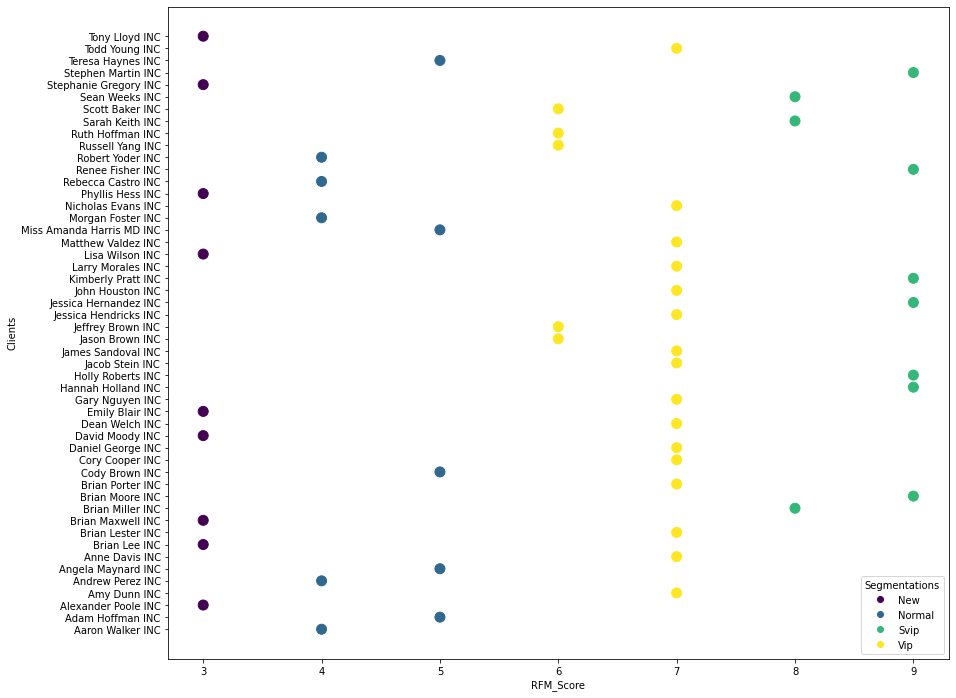

In [15]:
x=RFM_segment['RFM_Score']
y=RFM_segment['anonimized_name']
z=RFM_segment['Segmentations']
segmentation_name=['New','Normal','Svip','Vip']

plt.figure(figsize=(14,12))
plt.ticklabel_format(style = 'plain')
scatter = plt.scatter(x,
            y,
            s=100,
            c=RFM_segment.Segmentations.astype('category').cat.codes)
plt.legend(handles=scatter.legend_elements()[0], 
           labels = segmentation_name,
           title="Segmentations")
plt.xlabel('RFM_Score')
plt.ylabel('Clients')

# Check Skewness & Scaling

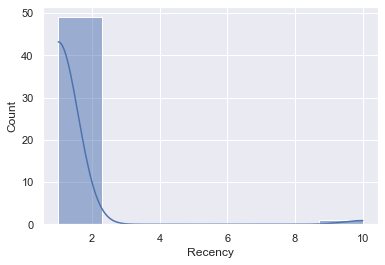

In [16]:
#Recency 
sns.set(style="darkgrid")
sns.histplot(clients, x='Recency',kde=True)
plt.show()

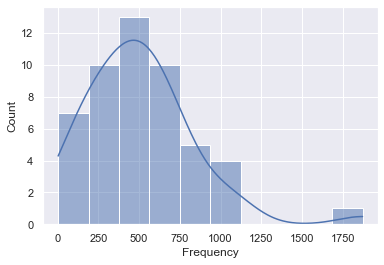

In [17]:
#Frequency
sns.set(style="darkgrid")
sns.histplot(clients, x='Frequency',kde=True)
plt.show()

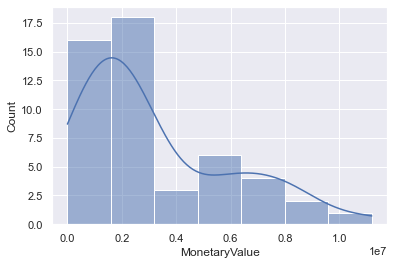

In [18]:
sns.set(style="darkgrid")
sns.histplot(clients, x='MonetaryValue',kde=True)
plt.show()

In [19]:
#Orginal Skewness
from scipy.stats import skew
Orginal_Recency_Skewness=skew(clients['Recency'],bias=False)
print('Original Recency Skweness is:',Orginal_Recency_Skewness)

Orginal_Frequency_Skewness=skew(clients['Frequency'],bias=False)
print('Original Frequency Skweness is:',Orginal_Frequency_Skewness)

Orginal_MonetaryValue_Skewness=skew(clients['MonetaryValue'],bias=False)
print('Original MonetaryValue Skweness is:',Orginal_MonetaryValue_Skewness)

Original Recency Skweness is: 7.071067811865476
Original Frequency Skweness is: 1.4707317303414462
Original MonetaryValue Skweness is: 1.1130050013688688


# Prepare Clusting

In [20]:
# box_cox Transformation
from scipy.stats import boxcox

boxcox_Recency_Skewness=boxcox(clients['Recency'])[0]
print('boxcox Recency Skweness is:',skew(boxcox_Recency_Skewness))

boxcox_Frequency_Skewness=boxcox(clients['Frequency'])[0]
print('boxcox Frequency Skweness is:',skew(boxcox_Frequency_Skewness))

boxcox_MonetaryValue_Skewness=boxcox(clients['MonetaryValue'])[0]
print('boxcox MonetaryValue Skweness is:',skew(boxcox_MonetaryValue_Skewness))

boxcox Recency Skweness is: 6.857142857142856
boxcox Frequency Skweness is: 0.005928383088425863
boxcox MonetaryValue Skweness is: -0.0675452526387535


In [21]:
#Use box_cox Transformation
from scipy import stats
rfm_boxcox = pd.DataFrame()
rfm_boxcox["Recency"] = stats.boxcox(clients['Recency'])[0]
rfm_boxcox["Frequency"] = stats.boxcox(clients['Frequency'])[0]
rfm_boxcox["MonetaryValue"] = stats.boxcox(clients['MonetaryValue'])[0]
rfm_boxcox.sample(5)

Recency  Frequency  MonetaryValue
17      0.0  48.381254     716.218049
42      0.0  50.611427    1072.258566
14      0.0  54.694839     610.263756
22      0.0  51.670828     778.328466
49      0.0  29.395611     437.739346

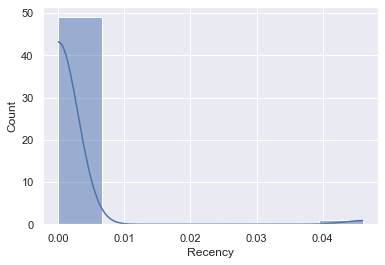

In [22]:
#Recency after transformation
sns.set(style="darkgrid")
sns.histplot(rfm_boxcox, x='Recency',kde=True)
plt.show()

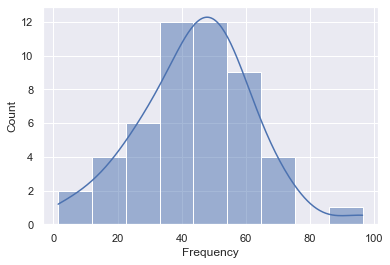

In [23]:
#Frequency after transformation
sns.set(style="darkgrid")
sns.histplot(rfm_boxcox, x='Frequency',kde=True)
plt.show()

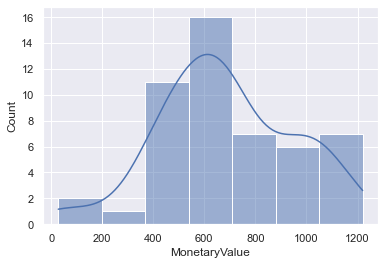

In [24]:
#MonetaryValue after transformation
sns.set(style="darkgrid")
sns.histplot(rfm_boxcox, x='MonetaryValue',kde=True)
plt.show()

In [25]:
#normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_boxcox)

rfm_normalized= scaler.transform(rfm_boxcox)

print(rfm_normalized.mean(axis=0).round(2))
print(rfm_normalized.std(axis=0).round(2))
rfm_normalized[1:6,:]

[0. 0. 0.]
[1. 1. 1.]


array([[-0.14285714, -1.44325764,  0.09828785],
       [-0.14285714, -1.54195211, -0.95896959],
       [-0.14285714,  0.67303774, -0.24386957],
       [-0.14285714, -0.95933255, -0.31903878],
       [-0.14285714, -0.09502368, -0.65676223]])

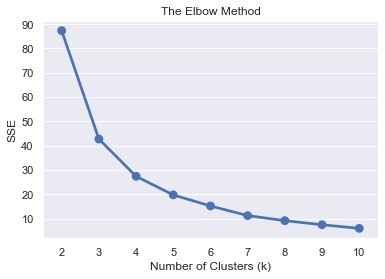

In [26]:
#k-means algorithm
from sklearn.cluster import KMeans
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [27]:
model=KMeans(n_clusters=4, random_state=42, n_init=10)
model.fit(rfm_normalized)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [28]:
#Interpre the Segment
clients['Cluster']=model.labels_
clients.groupby('Cluster').agg({'Recency':'mean',
                               'Frequency':'mean',
                               'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0           1.0    179.07    1033858.50    14
1           1.0    620.38    2113406.33    21
2           1.0    687.50    7146739.29    14
3          10.0      3.00        668.00     1

In [29]:
df_normalized = pd.DataFrame(rfm_normalized, columns=['Recency','Frequency','MonetaryValue'])
df_normalized['anonimized_name'] = clients.index
df_normalized['Cluster'] =model.labels_

#Melt the data
df_normalized_melt = pd.melt(df_normalized.reset_index(),
                             id_vars=['anonimized_name','Cluster'],
                             value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                             var_name='Metric',value_name='Value')

df_normalized_melt.sample(5)

anonimized_name  Cluster         Metric     Value
88   Renee Fisher INC        2      Frequency  0.880097
86   Phyllis Hess INC        0      Frequency -0.823955
42    Sarah Keith INC        2        Recency -0.142857
139  Robert Yoder INC        0  MonetaryValue -0.678355
94     Sean Weeks INC        2      Frequency  0.371647

<Axes: xlabel='Metric', ylabel='Value'>

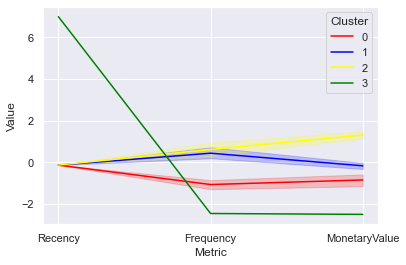

In [30]:
sns.lineplot(x='Metric',y='Value', hue='Cluster',palette=['red','blue','yellow','green'], data=df_normalized_melt)